# Prepare

## Install and Import libraries

In [31]:
! pip install torchaudio-augmentations

608.05s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [32]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None # avoids assignment warning
import numpy as np
import random
from glob import glob
from tqdm import tqdm
tqdm.pandas()  # enable progress bars in pandas operations
import gc

import librosa
import sklearn
import json

# Import for visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import librosa.display as lid
import IPython.display as ipd

# Import tensorflow
# import tensorflow as tf
# # Set logging level to avoid unnecessary messages
# tf.get_logger().setLevel('ERROR')
# # Set autograph verbosity to avoid unnecessary messages
# tf.autograph.set_verbosity(0)
# # Enable xla for speed up
# tf.config.optimizer.set_jit(True)

# Import required tensorflow modules
# import tensorflow_io as tfio
# import tensorflow_addons as tfa
# import tensorflow_probability as tfp
# import tensorflow.keras.backend as K

# Import KaggleDatasets for accessing Kaggle datasets
from kaggle_datasets import KaggleDatasets

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import transformers
from torchvision import transforms
from torch.cuda.amp import autocast as autocast, GradScaler
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import LambdaLR
from transformers.optimization import get_cosine_schedule_with_warmup
import torch.nn.functional as F

## Config

In [33]:
class CFG:
    # Debugging
    debug = False
    
    # Plot training history
    training_plot = True
    
    # Weights and Biases logging
    wandb = True
    competition   = 'birdclef-2023' 
    _wandb_kernel = 'awsaf49'
    
    # Experiment name and comment
    exp_name = 'baseline-v2'
    comment = 'EfficientNetB0|FSR|t=10s|128x384|up_thr=50|cv_filter'
    
    # Notebook link
    notebook_link = 'https://www.kaggle.com/awsaf49/birdclef23-effnet-fsr-cutmixup-train/edit'
    
    # Verbosity level
    verbose = 0
    
    # Device and random seed
    device = 'TPU-VM'
    seed = 42
    
    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 32
    upsample_thr = 50 # min sample of each class (upsample)
    cv_filter = True # always keeps low sample data in train
    
    # Inference batch size, test time augmentation, and drop remainder
    infer_bs = 2
    tta = 1
    drop_remainder = True
    
    # Number of epochs, model name, and number of folds
    epochs = 25
    model_name = 'EfficientNetB0'
    fsr = True # reduce stride of stem block
    num_fold = 5
    
    # Selected folds for training and evaluation
    selected_folds = [0]

    # Pretraining, neck features, and final activation function
    pretrain = 'imagenet'
    neck_features = 0
    final_act = 'softmax'
    
    # Learning rate, optimizer, and scheduler
    lr = 1e-3
    scheduler = 'cos'
    optimizer = 'Adam' # AdamW, Adam
    
    # Loss function and label smoothing
    loss = 'CCE' # BCE, CCE
    label_smoothing = 0.05 # label smoothing
    
    # Audio duration, sample rate, and length
    duration = 10 # second
    sample_rate = 32000
    audio_len = duration*sample_rate
    
    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    normalize = True
    
    # Data augmentation parameters
    augment=True
    
    # Spec augment
    spec_augment_prob = 0.80
    
    mixup_prob = 0.65
    mixup_alpha = 0.5
    
    cutmix_prob = 0.0
    cutmix_alpha = 0.5
    
    mask_prob = 0.65
    freq_mask = 20
    time_mask = 30


    # Audio Augmentation Settings
    audio_augment_prob = 0.5
    
    timeshift_prob = 0.0
    
    gn_prob = 0.35

    # Data Preprocessing Settings
    class_names = sorted(os.listdir('/kaggle/input/birdclef-2023/train_audio/'))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

    # Training Settings
    target_col = ['target']
    tab_cols = ['filename']
    monitor = 'auc'
    
    ### add by plathzheng
    unilm_model_path = './pretrained_models/unilm/BEATs_iter3_plus_AS2M.pt'
    use_apex = True

## Reproducibility

In [34]:
from transformers import set_seed
set_seed(CFG.seed)

## Device

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if CFG.debug:
    device = torch.device('cpu')

# Original Dataloader

In [36]:
BASE_PATH = '/kaggle/input/birdclef-2023'

if CFG.device=="TPU":
    from kaggle_datasets import KaggleDatasets
    GCS_PATH = KaggleDatasets().get_gcs_path(BASE_PATH.split('/')[-1])
else:
    GCS_PATH = BASE_PATH

In [37]:
df = pd.read_csv(f'{BASE_PATH}/train_metadata.csv')
df['filepath'] = GCS_PATH + '/train_audio/' + df.filename
df['target'] = df.primary_label.map(CFG.name2label)
df.head(2)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,target
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg,/kaggle/input/birdclef-2023/train_audio/abethr...,0
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg,/kaggle/input/birdclef-2023/train_audio/abethr...,0


## Data utils

In [38]:
import cv2

def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

def show_image(filename):
    img = cv2.imread(f'/kaggle/input/birdclef23-image-dataset/{filename}.jpg')
    img = img[...,::-1] # bgr => rgb
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('OFF')
    plt.show()
    return img

def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio, sr=CFG.sample_rate, 
                                   n_mels=CFG.img_size[0],
                                   n_fft=CFG.nfft,
                                   hop_length=CFG.hop_length,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=np.max)
    return spec

def display_audio(row):
    # Caption for viz
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name} | Rating: {row.rating}'
    # Read audio file
    audio, sr = load_audio(row.filepath)
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    # print("# Image:")
    # show_image(row.common_name)
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0])
    # Specplot
    lid.specshow(spec, 
                 sr = CFG.sample_rate, 
                 hop_length = CFG.hop_length,
                 n_fft=CFG.nfft,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time', 
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

## show data

In [39]:
stat = df.primary_label.value_counts().index.tolist()
class_names = stat[:3] + stat[-3:] # popular + not popular
print(class_names)

['barswa', 'wlwwar', 'thrnig1', 'whhsaw1', 'afpkin1', 'crefra2']


# Category: barswa
# Num Samples: 500
# Audio:


# Visualization:


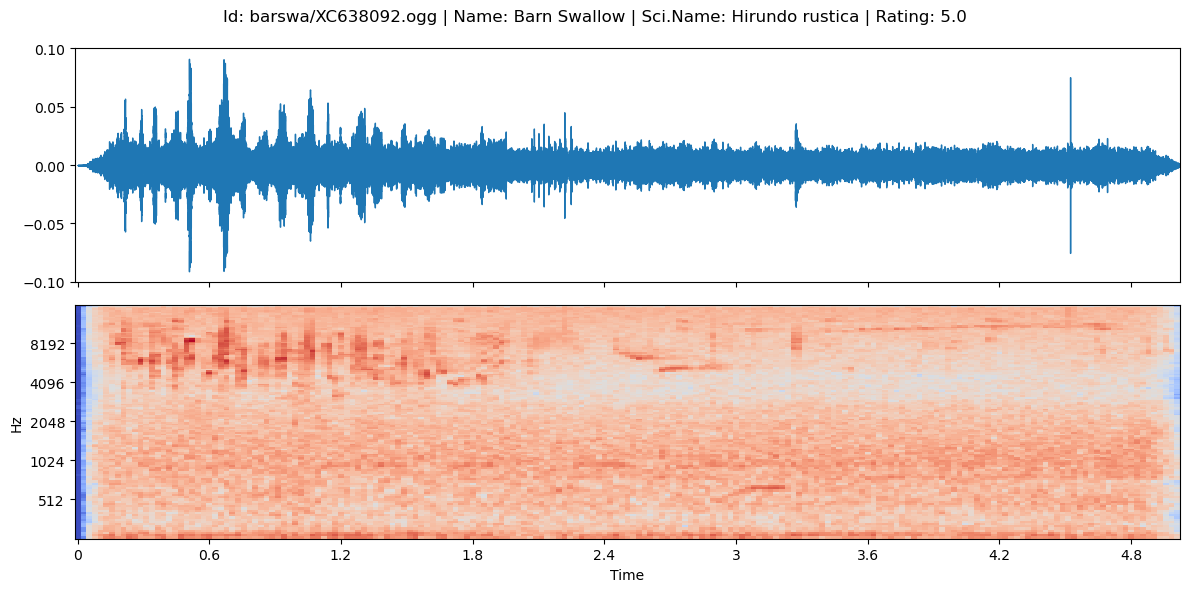

In [40]:
class_name = class_names[0]
print(f'# Category: {class_name}')
class_df = df.query("primary_label==@class_name")
print(f'# Num Samples: {len(class_df)}')
row = class_df.sample(1).squeeze()

# Display audio
display_audio(row)

## Data split

In [41]:
# Import required packages
from sklearn.model_selection import StratifiedKFold

# Initialize the StratifiedKFold object with 5 splits and shuffle the data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

# Reset the index of the dataframe
df = df.reset_index(drop=True)

# Create a new column in the dataframe to store the fold number for each row
df["fold"] = -1

# Iterate over the folds and assign the corresponding fold number to each row in the dataframe
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['primary_label'])):
    df.loc[val_idx, 'fold'] = fold

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


In [42]:
df.groupby(['fold','primary_label']).size()

fold  primary_label
0     abethr1           3
      abhori1          26
      abythr1           5
      afbfly1           4
      afdfly1           6
                       ..
4     yertin1          27
      yesbar1           6
      yespet1           3
      yetgre1           5
      yewgre1          22
Length: 1271, dtype: int64

In [43]:
df.head(2)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,target,fold
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg,/kaggle/input/birdclef-2023/train_audio/abethr...,0,3
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg,/kaggle/input/birdclef-2023/train_audio/abethr...,0,3


## Filter Data and Upsample Data

In [44]:
def filter_data(df, thr=5):
    # Count the number of samples for each class
    counts = df.primary_label.value_counts()

    # Condition that selects classes with less than `thr` samples
    cond = df.primary_label.isin(counts[counts<thr].index.tolist())

    # Add a new column to select samples for cross validation
    df['cv'] = True

    # Set cv = False for those class where there is samples less than thr
    df.loc[cond, 'cv'] = False

    # Return the filtered dataframe
    return df
    
def upsample_data(df, thr=20):
    # get the class distribution
    class_dist = df['primary_label'].value_counts()

    # identify the classes that have less than the threshold number of samples
    down_classes = class_dist[class_dist < thr].index.tolist()

    # create an empty list to store the upsampled dataframes
    up_dfs = []

    # loop through the undersampled classes and upsample them
    for c in down_classes:
        # get the dataframe for the current class
        class_df = df.query("primary_label==@c")
        # find number of samples to add
        num_up = thr - class_df.shape[0]
        # upsample the dataframe
        class_df = class_df.sample(n=num_up, replace=True, random_state=CFG.seed)
        # append the upsampled dataframe to the list
        up_dfs.append(class_df)

    # concatenate the upsampled dataframes and the original dataframe
    up_df = pd.concat([df] + up_dfs, axis=0, ignore_index=True)
    
    return up_df

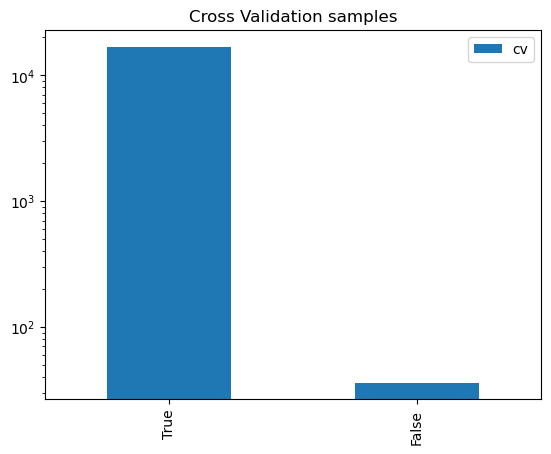

In [45]:
# Filter data
f_df = filter_data(df, thr=5)
f_df.cv.value_counts().plot.bar(legend=True)
plt.yscale("log")
plt.title("Cross Validation samples")
plt.show()

Before Upsample Size: 16941
After Upsample Size: 22208


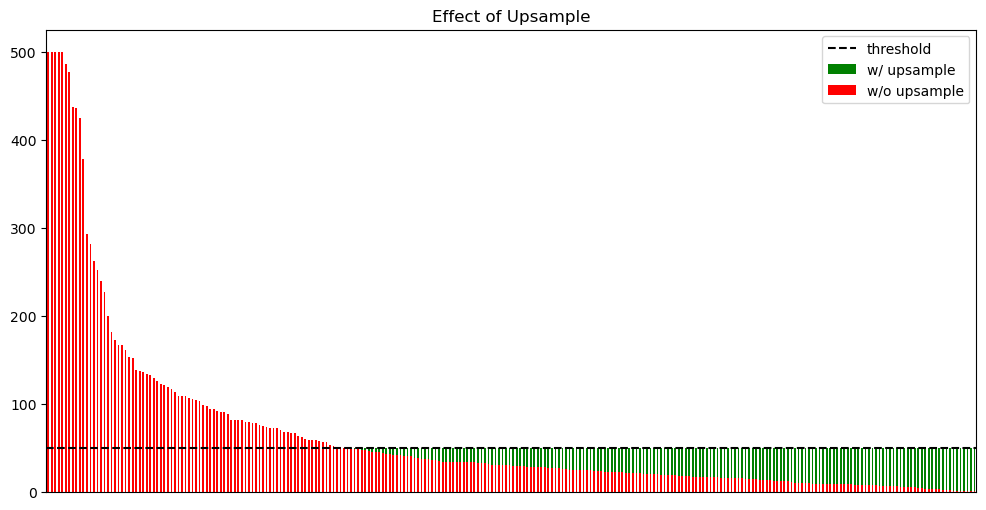

In [46]:
# Upsample data
up_df = upsample_data(df, thr=50)
print(f'Before Upsample Size: {len(df)}')
print(f'After Upsample Size: {len(up_df)}')

# Show effect of upsample
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
up_df.primary_label.value_counts()[:].plot.bar(ax=ax, color='green', label='w/ upsample')
df.primary_label.value_counts()[:].plot.bar(ax=ax, color='red', label='w/o upsample')
plt.xticks([])
plt.axhline(y=50, color='k', linestyle='--', label='threshold')
plt.legend()
plt.title("Effect of Upsample")
plt.show()

## Audio Augmentation

In [47]:
from torchaudio.utils import download_asset
import torchaudio
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")
audio_data, sr = torchaudio.load(SAMPLE_SPEECH)
print(sr)
print(audio_data.shape)

8000
torch.Size([1, 27200])


In [48]:
from torchaudio_augmentations import *

def audio_augmentation(audio_data : torch.Tensor, sr: int, 
                       num_augmented_sampels=4,
                       num_samples=16000,
                       polarity_p=0.8, 
                       min_snr=0.001, 
                       max_snr=0.005, 
                       noise_p=0.3, 
                       gain_p=0.2, 
                       delay_p=0.5, 
                       shift_p=0.4, 
                       reverb_p=0.3):
    if num_samples>max(audio_data.shape):
        num_samples = max(audio_data.shape)
    
    transforms = [
                RandomResizedCrop(n_samples=num_samples),
                RandomApply([PolarityInversion()], p=polarity_p),
                RandomApply([Noise(min_snr=min_snr, max_snr=max_snr)], p=noise_p),
                RandomApply([Gain()], p=gain_p),
                HighLowPass(sample_rate=sr), # this augmentation will always be applied in this aumgentation chain!
                RandomApply([Delay(sample_rate=sr)], p=delay_p),
                RandomApply([PitchShift(
                    n_samples=num_samples,
                    sample_rate=sr
                )], p=shift_p),
                RandomApply([Reverb(sample_rate=sr)], p=reverb_p)]   
    transforms = ComposeMany(transforms=transforms, num_augmented_samples=num_augmented_sampels)
    audio_aug = transforms(audio_data)
    return audio_aug

# num_samples = sr * 2
# transforms = [
#     RandomResizedCrop(n_samples=num_samples),
#     RandomApply([PolarityInversion()], p=0.8),
#     RandomApply([Noise(min_snr=0.001, max_snr=0.005)], p=0.3),
#     RandomApply([Gain()], p=0.2),
#     HighLowPass(sample_rate=sr), # this augmentation will always be applied in this aumgentation chain!
#     RandomApply([Delay(sample_rate=sr)], p=0.5),
#     RandomApply([PitchShift(
#         n_samples=num_samples,
#         sample_rate=sr
#     )], p=0.4),
#     RandomApply([Reverb(sample_rate=sr)], p=0.3)
# ]
# audio_transforms = ComposeMany(transforms=transforms, num_augmented_samples=4)
# audio_aug = audio_transforms(audio_data)
# print(audio_aug.shape)
audio_aug = audio_augmentation(audio_data, sr, num_augmented_sampels=4, num_samples=sr*2)

# Audio:


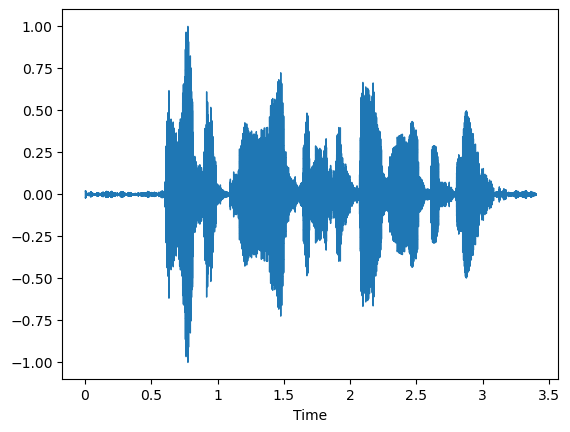

In [49]:
print("# Audio:")
display(ipd.Audio(audio_data, rate=sr))
lid.waveshow(audio_data.numpy(), sr=sr)


# Augmetation Audio 1:


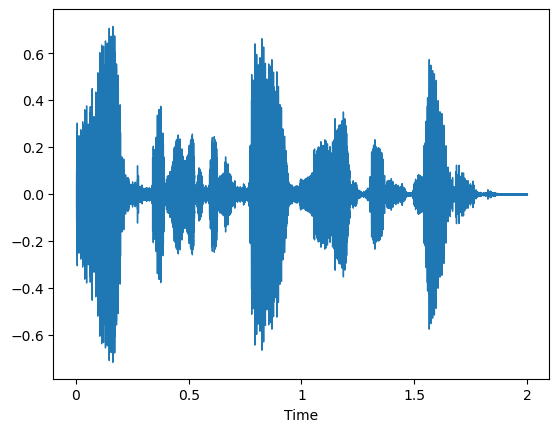

In [50]:
print("# Augmetation Audio 1:")
display(ipd.Audio(audio_aug[0], rate=sr))
lid.waveshow(audio_aug[0].numpy(), sr=sr)

In [51]:
# easy mixup pytorch implemention from https://github.com/hongyi-zhang/mixup
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index,:]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(y_a, y_b, lam):
    return lambda criterion, pred: lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# def train(epoch, net, trainloader, optimizer, criterion):
#     print('\nEpoch: %d' % epoch)
#     net.train()
#     train_loss = 0
#     correct = 0
#     total = 0
#     for batch_idx, (inputs, targets) in enumerate(trainloader):
#         inputs, targets = inputs.cuda(), targets.cuda()
#         # generate mixed inputs, two one-hot label vectors and mixing coefficient
#         inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, args.alpha, use_cuda)
#         optimizer.zero_grad()
#         inputs, targets_a, targets_b = Variable(inputs), Variable(targets_a), Variable(targets_b)
#         outputs = net(inputs)

#         loss_func = mixup_criterion(targets_a, targets_b, lam)
#         loss = loss_func(criterion, outputs)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.data[0]
#         _, predicted = torch.max(outputs.data, 1)
#         total += targets.size(0)
#         correct += lam * predicted.eq(targets_a.data).cpu().sum() + (1 - lam) * predicted.eq(targets_b.data).cpu().sum()

#         progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#             % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
#     return (train_loss/batch_idx, 100.*correct/total)

## Dataloader

In [52]:
def audio_fixlength(raw: np.array, input_length: int):
    length = len(raw)
    factor = input_length // length + 1
    raw = [raw for _ in range(factor)]
    raw = np.stack(raw, axis=0)
    raw = raw.flatten()
    return raw

class AudioDataset(Dataset):
    def __init__(self, df, mode='train', transform=None):
        self.mode = mode
        if CFG.cv_filter:
            train_df = df.query("fold!=@fold | ~cv").reset_index(drop=True)
            valid_df = df.query("fold==@fold & cv").reset_index(drop=True)
        else:
            train_df = df.query("fold!=@fold").reset_index(drop=True)
            valid_df = df.query("fold==@fold").reset_index(drop=True)

        self.input_length = CFG.sample_rate * 4  # choose 4 seconds samples in training
        
        # Upsample train data
        train_df = upsample_data(train_df, thr=CFG.upsample_thr)
        
        # Get file paths and labels
        self.train_paths = train_df.filepath.values
        self.train_labels = train_df.target.values
        self.valid_paths = valid_df.filepath.values
        self.valid_labels = valid_df.target.values

        self.transform = transform

    def __len__(self):
        return max(len(self.train_paths), len(self.valid_paths))

    def __getitem__(self, idx):
        if self.mode=='train':
            audio_path = self.train_paths[idx%len(self.train_paths)]
            label = self.train_labels[idx%len(self.train_paths)]
        else:
            audio_path = self.valid_paths[idx%len(self.valid_paths)]
            label = self.valid_labels[idx%len(self.valid_paths)]
        
        sig, sr = librosa.load(audio_path, sr=CFG.sample_rate, mono=True)
        if len(sig) < self.input_length:
            sig = audio_fixlength(sig, self.input_length)
            
        if self.mode=='test':  
            hop = (len(sig) - self.input_length) // CFG.batch_size
            x = [torch.Tensor(np.float32(sig[i*hop:i*hop+self.input_length])) for i in range(CFG.batch_size)] 
            x = torch.stack(x)
            padding_mask = torch.zeros(CFG.batch_size, x.shape[1]).bool()
            return x, padding_mask, label
    
        elif self.mode=='train' or self.mode=='eval':
            sig_t = torch.tensor(sig)
            sig_t = sig_t.unsqueeze(0)
            sig_t = audio_augmentation(sig_t, sr, num_augmented_sampels=1, num_samples=self.input_length)
            sig_t = sig_t.squeeze()
            padding_mask = torch.zeros(1, sig_t.shape[0]).bool().squeeze(0)
            if self.transform:
                sig_t = self.transform(sig_t)
            return sig_t, padding_mask, label

# sample dataset:


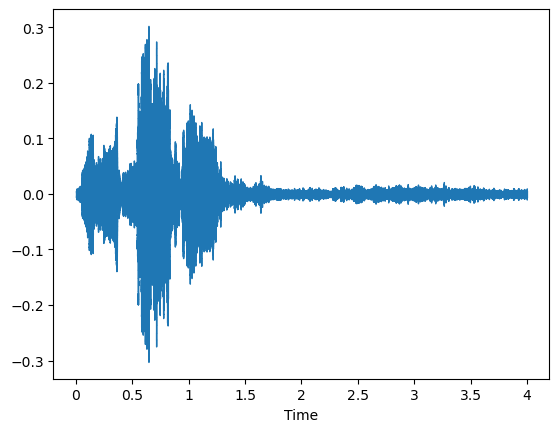

In [53]:
dataset = AudioDataset(df, mode='train')
dataset_0 = dataset[0][0]
dataset_0 = dataset_0.cpu().numpy()
print("# sample dataset:")
display(ipd.Audio(dataset_0, rate=CFG.sample_rate))
lid.waveshow(dataset_0, sr=CFG.sample_rate)

# Modeling

## Loss, Metrics, Lr Scheduler

In [54]:
def measurement(y_true, y_pred, padding_factor=5):
    num_classes = y_true.shape[1]
    pad_rows = np.array([[1]*num_classes]*padding_factor)
    y_true = np.concatenate([y_true, pad_rows])
    y_pred = np.concatenate([y_pred, pad_rows])
    score = sklearn.metrics.average_precision_score(y_true, y_pred, average='macro',)
    roc_aucs = sklearn.metrics.roc_auc_score(y_true, y_pred, average='macro')
    return score, roc_aucs

if CFG.loss=='CCE':
    loss_fct = nn.CrossEntropyLoss(label_smoothing=CFG.label_smoothing)
elif CFG.loss=='BCE':
    loss_fct = nn.BCELoss()

## Modeling

In [55]:
from pretrained_models.unilm.BEATs.BEATs import BEATs, BEATsConfig

class BirdModel(nn.Module):
    def __init__(self,):
        super().__init__()
        self.num_target_classes = CFG.num_classes
        self.checkpoint = torch.load(CFG.unilm_model_path)
        self.cfg = BEATsConfig(
            {
                **self.checkpoint["cfg"],
                "predictor_class": self.num_target_classes,
                "finetuned_model": False,
            }
        )
        
        self._build_model()
        
    def _build_model(self):
        # 1. Load the pre-trained network
        self.beats = BEATs(self.cfg)
        self.beats.load_state_dict(self.checkpoint["model"])

        # 2. Classifier
        self.fc = nn.Linear(self.cfg.encoder_embed_dim, self.cfg.predictor_class)

    def forward(self, x, padding_mask=None):
        """Forward pass. Return x"""

        # Get the representation
        if padding_mask != None:
            x, _ = self.beats.extract_features(x, padding_mask, sample_frequency=CFG.sample_rate)
        else:
            x, _ = self.beats.extract_features(x, sample_frequency=CFG.sample_rate)

        # Get the logits
        x = self.fc(x)

        # Mean pool the second layer
        x = x.mean(dim=1)

        return x  

## Training

In [56]:
def set_device(batch: list):
    for index, item in enumerate(batch):
        batch[index] = item.to(device)
    return batch

def train_step(model: nn.Module, loader, optimizer, scaler, lr_scheduler, loss_fct, model_name='pytorch_model.pth'):
    model = model.to(device)
    model.train()
    for batch in loader:
        batch = set_device(batch)
        audio, mask, label = batch
        prob = model(audio, mask)
        loss = loss_fct(prob, label)
        if CFG.use_apex:
            scaler.scale(loss).backward()
            lr_scheduler.step()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

def eval_step(model: nn.Module, loader, loss_fct, best_metric, cur_epoch, model_name='pytorch_model.pth'):
    model = model.to(device)
    model.eval()
    label_stack = []
    pred_stack = torch.randn(size=(1, CFG.num_classes)).to(device)
    losses = []
    for batch in loader:
        batch = set_device(batch)
        audio, mask, label = batch
        with torch.no_grad():
            prob = model(audio, mask)
            loss = loss_fct(prob, label)
            losses.append(loss.item())
        label_stack += label.cpu().numpy().tolist()
        pred_stack = torch.cat([pred_stack, prob], dim=0)
    cur_loss = np.array(losses).mean(0)
    pred_stack = pred_stack[1:]
    pred_stack = pred_stack.detach().cpu().numpy()
    label_stack = np.array(label_stack)
    acc, auc = measurement(label_stack, pred_stack)
    if cur_epoch%10==0:
        print("cur loss: {:.4} --- acc: {:.4} --- auc: {:.4}".format(cur_loss, acc, auc))
    if auc>best_metric:
        best_metric = auc
        torch.save(model.state_dict(), model_name)
    return best_metric
        

def train(model, loader_train, loader_eval, optimizer, scaler, lr_scheduler, loss_fct, model_name='pytorch_model.pth'):
    best_metric = 0
    # for fold in range(CFG.num_fold):
    for epoch in range(CFG.epochs):
        train_step(model, loader_train, optimizer, scaler, lr_scheduler, loss_fct)
        best_metric = eval_step(model, loader_eval, loss_fct, best_metric, epoch, model_name)    



In [57]:
train_dataset = AudioDataset(df, mode='train')
loader_train = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=0)
eval_dataset = AudioDataset(df, mode='eval')
loader_eval = DataLoader(eval_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=0)

model = BirdModel()
optimizer = torch.optim.Adam(model.parameters(), CFG.lr)

total_samples = train_dataset.__len__()
num_warmup_steps = (total_samples // CFG.batch_size) * 2
num_total_steps = (total_samples // CFG.batch_size) * CFG.epochs
lr_scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_total_steps)

if CFG.use_apex:
    scaler = GradScaler()
else:
    scaler = None

train(model, loader_train, loader_eval, optimizer, scaler, lr_scheduler, loss_fct, model_name='unilm.pth')

/opt/conda/lib/python3.7/site-packages/torch/cuda/__init__.py:155: UserWarning: 
NVIDIA GeForce RTX 3080 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_60 sm_70 sm_75 compute_70 compute_75.
If you want to use the NVIDIA GeForce RTX 3080 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))
